Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0 (Conv2D)                (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv0_0[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

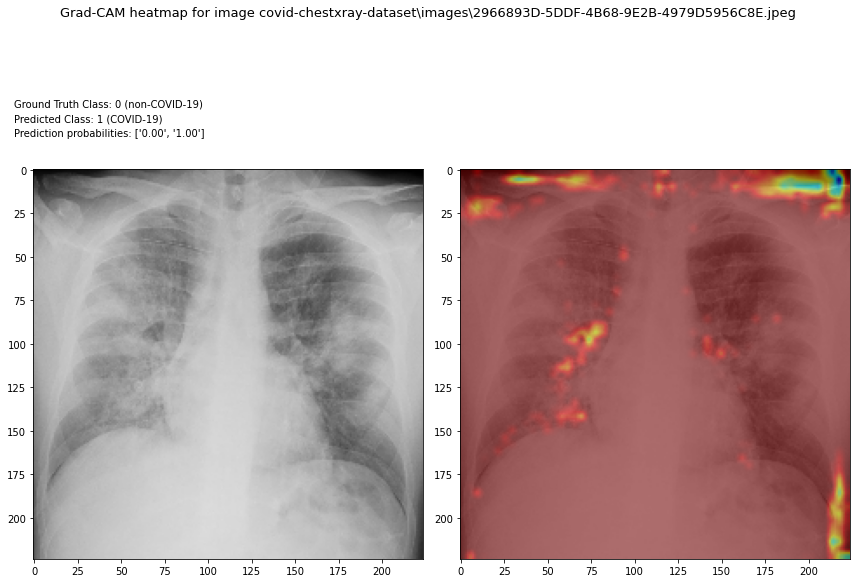

In [1]:
import yaml
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from preprocess import remove_text
from predict import predict_instance
from visualization.visualize import visualize_heatmap

def setup_gradcam():
    '''
    Load relevant variables to apply Grad-CAM
    :return: dict containing important information and objects for Grad-CAM visualizations
    '''

    cfg = yaml.full_load(open("C:\\Users\\PaulDS3\\Downloads\\project\\covid_cxr\\config.yml", 'r'))
    setup_dict = {}

    setup_dict['MODEL'] = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)
    setup_dict['MODEL'].summary()

    # Get name of final convolutional layer
    layer_name = ''
    for layer in setup_dict['MODEL'].layers:
        if any('Conv2D' in l for l in layer._keras_api_names):
            layer_name = layer.name
    setup_dict['LAYER_NAME'] = layer_name

    setup_dict['IMG_PATH'] = cfg['PATHS']['IMAGES']
    setup_dict['RAW_DATA_PATH'] = cfg['PATHS']['RAW_DATA']
    setup_dict['TEST_SET'] = pd.read_csv(cfg['PATHS']['TEST_SET'])
    setup_dict['IMG_DIM'] = cfg['DATA']['IMG_DIM']
    setup_dict['CLASSES'] = cfg['DATA']['CLASSES']

    # Create ImageDataGenerator for test set
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=setup_dict['TEST_SET'],
                                                      directory=cfg['PATHS']['RAW_DATA'],
                                                      x_col="filename", y_col='label_str',
                                                      target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
                                                      class_mode='categorical', validate_filenames=False, shuffle=False)
    setup_dict['TEST_GENERATOR'] = test_generator
    return setup_dict

def apply_gradcam(setup_dict, idx, hm_intensity=0.5, save_hm=True):
    '''
    Make a prediction and overlay a heatmap depicting the gradient of the predicted class with respect to the output of
    a layer of the model.
    :param setup_dict: dict containing important information and objects for Grad-CAM
    :param idx: index of image in test set to explain
    :param save_hm: Boolean indicating whether to save the heatmap visualization
    '''

    # Get i'th preprocessed image in test set
    setup_dict['TEST_GENERATOR'].reset()
    for i in range(idx + 1):
        x, y = setup_dict['TEST_GENERATOR'].next()

    # Get the corresponding original image (no preprocessing)
    orig_img = cv2.imread(setup_dict['RAW_DATA_PATH'] + setup_dict['TEST_SET']['filename'][idx])
    new_dim = tuple(setup_dict['IMG_DIM'])
    orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

    # Predict this example
    probs = predict_instance(x, setup_dict['MODEL'])

    # Rearrange prediction probability vector to reflect original ordering of classes in project config
    probs = [probs[0][setup_dict['CLASSES'].index(c)] for c in setup_dict['TEST_GENERATOR'].class_indices]

    with tf.GradientTape() as tape:
        last_conv_layer = setup_dict['MODEL'].get_layer(setup_dict['LAYER_NAME'])
        iterate = Model([setup_dict['MODEL'].inputs], [setup_dict['MODEL'].output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0.0)    # Equivalent of passing through ReLU
    heatmap /= np.max(heatmap)
    heatmap = heatmap.squeeze(axis=0)
    heatmap = cv2.resize(heatmap, tuple(setup_dict['IMG_DIM']))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_img = cv2.addWeighted(heatmap, hm_intensity, orig_img, 1.0 - hm_intensity, 0)

    # Visualize the Grad-CAM heatmap and optionally save it to disk
    if save_hm:
        file_path = setup_dict['IMG_PATH']
    else:
        file_path = None
    img_filename = setup_dict['TEST_SET']['filename'][idx]
    label = setup_dict['TEST_SET']['label'][idx]
    _ = visualize_heatmap(orig_img, heatmap_img, img_filename, label, probs, setup_dict['CLASSES'],
                              dir_path=file_path)
    return heatmap

if __name__ == '__main__':
    setup_dict = setup_gradcam()
    heatmap = apply_gradcam(setup_dict, 10, hm_intensity=0.5, save_hm=True)    # Generate heatmap for image

